In [5]:
from dask.distributed import Client

client = Client('tcp://127.0.0.1:33047')

In [6]:
import matplotlib as plt

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['image.cmap'] = 'gray'

In [23]:
import glob, os
path = '/hpc/vvib872/Data/PSF/PSF149/561'
filenames = sorted(glob.glob(os.path.join(path,"*.tif")))
z_slices = len(filenames)
z_slices

451

In [24]:
from skimage import io
sample = io.imread(filenames[130])
sample.shape

(2048, 10719)

In [25]:
import math

c = (256,256)
print(tuple(map(lambda x,c: (math.floor(x/c) * c ),sample.shape,c)))
tuple(map(lambda x,c: (math.floor(x/c) * c - x),sample.shape,c))

(2048, 10496)


(0, -223)

(2048, 10496)

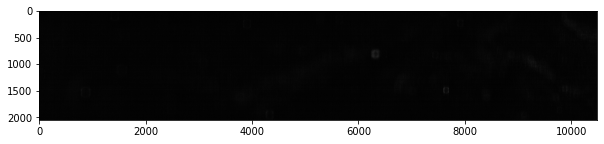

In [26]:
import matplotlib.pyplot as plt
import skimage.io
from skimage.exposure import rescale_intensity
import numpy as np

cropped = sample[:,:-223]

plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
imgplot = plt.imshow(cropped, clim=(0,100))
cropped.shape

In [27]:
import dask
import dask.array as da

z_range = slice(None,None)
xy_range = (slice(None,None), slice(None,-223))
dtype = 'uint16'


lazy_arrays = [dask.delayed(io.imread)(fn) for fn in filenames][z_range]
lazy_arrays = [da.from_delayed(x[xy_range], shape=sample[xy_range].shape, dtype=dtype)
               for x in lazy_arrays]

da_img = da.stack(lazy_arrays)
da_img

,Array,Chunk
Bytes,19.39 GB,42.99 MB
Shape,"(451, 2048, 10496)","(1, 2048, 10496)"
Count,1804 Tasks,451 Chunks
Type,uint16,numpy.ndarray


In [29]:
import zarr
import math

z_chunk = (226,)
chunks = z_chunk+ c

shape = tuple(map(lambda x,c: (math.ceil(x/c) * c ),da_img.shape,chunks))

store = zarr.NestedDirectoryStore(path + ".zarr")
z_out = zarr.create(shape=shape,chunks=chunks, dtype=da_img.dtype, store=store, overwrite=True, fill_value=0)
z_out.info

Type,zarr.core.Array
Data type,uint16
Shape,"(452, 2048, 10496)"
Chunk shape,"(226, 256, 256)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.NestedDirectoryStore
No. bytes,19432210432 (18.1G)
No. bytes stored,368
Storage ratio,52804919.7


In [107]:
import json

metadata = {
        'path': path,
        'chunks': chunks,
        'z_range':[z_range.start, z_range.stop],
        'xy_range':[[xy_range[0].start, xy_range[0].stop],[xy_range[1].start, xy_range[1].stop]],
        'dtype':dtype        
    }

metadata_file = path + '.json'
with open(metadata_file, 'w') as outfile:
    json.dump(metadata, outfile)

print(metadata_file)

/hpc/vvib872/Data/MuSIC/Carotid-6R/Slices.json


In [30]:
%%time
da.to_zarr(da_img, z_out)

CPU times: user 720 ms, sys: 28 ms, total: 748 ms
Wall time: 49.8 s
